# Scraping and Classifying Lost and Found Posts from Craigslist
This project was inspired by a desire to discover which items most frequently appear in lost and found posts on Craigslist in the bay area and to uncover meaningful trends in the data. This tutorial teaches you how to scrape text from Craigslist posts using Scrapy. We proceed to organize and store the scraped text using Pandas dataframes and pre-process and analyze the scraped text using Natural Language Toolkit NLTK. We conclude by building a Naive Bayes classification model to predict whether a post is lost or found, and what category of item is being described in the  post: cat, dog, phone, keys, wedding band, wallet, purse, or backpack, etc.

## The Origins of Lost and Found

In Japan, the lost-and-found property system dates to a code written in the year 718. [citation](https://www.nytimes.com/2004/01/08/world/never-lost-but-found-daily-japanese-honesty.html)

St. Anthony is invoked as the patron saint of lost things through this popular jingle: “St. Anthony, please look around; there  is something lost that must be found.” [citation](http://catholicstraightanswers.com/who-is-st-anthony-and-why-is-he-the-patron-saint-of-lost-things/)

## The Demographics of Lost Cats and Dogs

Many of the lost and found posts on Craigslist are for cats and dogs. Over a five year period about 15% of dog and cat owners lose their pets. Dogs have a higher recovery rate (93%) than cats (75%).  Read on to find out how these demographic trends are reflected in the data we scraped and analyzed. [citation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5789300/)


## Creating a Virtual Environment & Installing Scrapy
It is advisable to install Scrapy in a [virtual environment](https://realpython.com/python-virtual-environments-a-primer/) to avoid package dependency conflicts.

With a virtual environment activated, you can safely install [Scrapy](https://docs.scrapy.org/en/latest/) using pip with the following command:
 `(env)$ pip install scrapy`


## Creating a Scrapy Project
In Terminal navigate to the folder where you would like to save this project and run this command:


`(env)$ scrapy startproject craigslist`
 
Create a spider using the genspider command and give it any name you like; here we will call it lost_found. The title of the spider should be followed by the URL.

`(env)$ lost_found https://sfbay.craigslist.org/d/lost-found/search/laf`


Editing the Scrapy Spider: Manually navigate to the folder containing our scrapy project, `craigslist`

We will focus on the spider file, titled `lost_found.py` – open it in any text editor. You will find the following code already generated by Scrapy:


In [ ]:
import scrapy
 
class LostFoundSpider(scrapy.Spider):
    name = "lost_found"
    allowed_domains = ["craigslist.org"]
    start_urls = ['https://sfbay.craigslist.org/d/lost-found/search/laf']
 
    def parse(self, response):
        pass
 
We edit this stub code to create a spider designed to scrape lost and found ads from Craigslist in the Bay Area:

import scrapy
from scrapy.http.request import Request

class LostFoundSpider(scrapy.Spider):
    name = 'lost_found'
    allowed_domains = ['craigslist.org']
    start_urls = ['https://sfbay.craigslist.org/d/lost-found/search/laf']

    def parse(self, response):
        posts = response.xpath('//p[@class="result-info"]')
 
        for post in posts:
            relative_url = post.xpath('a/@href').extract_first()
            absolute_url = response.urljoin(relative_url)
            title = post.xpath('a/text()').extract_first()
            address = post.xpath('span[@class="result-meta"]/span[@class="result-hood"]/text()').extract_first("")[2:-1]

            yield Request(absolute_url, callback=self.parse_page, meta={'URL': absolute_url, 'Title': title, 'Address':address})
 
        relative_next_url = response.xpath('//a[@class="button next"]/@href').extract_first()
        absolute_next_url = "https://sfbay.craigslist.org" + relative_next_url
 
        yield Request(absolute_next_url, callback=self.parse)
 
    def parse_page(self, response):
        url = response.meta.get('URL')
        title = response.meta.get('Title')
        address = response.meta.get('Address')
        description = "".join(line for line in response.xpath('//*[@id="postingbody"]/text()').extract())
        post_date = response.xpath('//time[contains(@class, "timeago")]/@datetime').extract_first()

        yield{'URL': url, 'Title': title, 'Address':address, 'Description':description, 'PostDate':post_date}


## `response` and XPath

Take note of these elements in the code above: `response` is the whole html source code retrieved from the page by Scrapy. We use [XPath]((https://docs.scrapy.org/en/xpath-tutorial/topics/xpath-tutorial.html)) expressions, such as `response.xpath('//*[@id="postingbody"]/text()').extract()` to extract portions of text from the HTML.


## Running the Scrapy Spider & Storing the Scraped Data in CSV Format

You may run your spider and store the output data into CSV, JSON or XML. To store the data into CSV, run the following command in Terminal. The result will be a CSV file called result-titles.csv in your Scrapy spider directory.

`(env) $ scrapy crawl lost_found -o result-lost_found.csv`

Your Terminal will become a blur of scrolling text as it shows you what your spider is scraping line by line in real time.

Once the scraper is executed using the code above, a file titled `result-lost_found.csv` is created in the `craigslist` project directory. This file can be viewed and modified using any spreadsheet application. 

The next stage of the project requires the installation of additional python packages contained in [Anaconda](https://docs.anaconda.com/anaconda/install/)



## Scrapy Settings
Edit the Scrapy `settings.py` file to make your scraping look more natural and identify yourself on the user agent: 
`USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3)'` 
Decrease the likelihood of being banned from a website by adding a [download delay](https://doc.scrapy.org/en/latest/topics/settings.html#download-delay) between each Scrapy request to the same website:
`DOWNLOAD_DELAY = 3`

# Automating Text Classification through Machine Learning 

In the final stage of our project we build machine learning classification models to predict whether a post is lost or found, and what category of item is being described in the  post: cat, dog, phone, keys, wedding band, or wallet, purse, backpack, etc.

## Manually Labeling Lost and Found Posts

Supervised machine learning methods such as the Naive Bayes classification model require large sets of manually labeled data to train the model to automatically classify posts. We begin the labor-intensive process of manually labeling our data by exporting our processed dataframe as a .csv file to view and edit it in a spreadsheet program such as Excel or Numbers.

When you open the .csv file the “Description” column may not appear to contain any data. Resize that column, making it wider. Select all of the cells in that column and apply Wrap Text formatting to them. You should now be able to view the full description of each lost and found post.

Create a new column for labels indicating whether each post is for a lost or found item.
Create another new column for labels indicating which item has been lost in each post. Create a third column to mark duplicate posts for deletion from the data set using a binary indicator, “1” for duplicate posts to be deleted.

Read the title and description of all the posts you have scraped and label each post as “lost” or “found” in the first column and label each post as “cat”, “dog”, “phone”, “keys”, “ring”, “wallet”, “purse”, “backpack”, etc.
If you have hundreds or thousands of posts this may take several hours. 

With a labeled dataset and duplicate posts marked for deletion, we proceed to further analyze the text of the posts and build a classification algorithm to predict which category each post belongs to.

We initiate a [Jupyter Notebook](https://jupyter.org/) session and proceed with further Natural Language Processing of the scraped lost and found posts. 
Initiate a Jupyter Notebook session by entering this command in Terminal:
`$ jupyter notebook`


## Import Python Packages

In [76]:
import nltk
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sb
from textblob import TextBlob, Word
#import warnings
#warnings.filterwarnings('ignore')

## Import Scraped and Labeled Data from CSV File as a Pandas Dataframe

In [77]:
df = pd.read_csv('join_label_lf_042719aa.csv', index_col=None, header=0)

## Clean, Validate, and Pre-Process Data
### Drop duplicate rows, drop rows containing NaN values in key fields

In [78]:
df = df.drop_duplicates(subset='Description', keep='first')
df = df[df['Description'].notnull()]
df = df[df.Drop != 1]
df = df[df.Irrelevant != 1]
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.shape

(954, 14)

## Count the number of words in this corpus of text before removing stopwords 

In [79]:
df['Description'].apply(lambda x: len(str(x).split(" "))).sum()

55436

## Remove Stopwords

In [138]:
df["Title"] = df["Title"].str.lower().str.split()
df["Description"] = df["Description"].str.lower().str.split()
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['desc_nsw'] = df['Description'].apply(lambda x: [item for item in x if item not in stop])
df["Title"] = df["Title"].str.join(' ')
df["Description"] = df["Description"].str.join(' ')
df["desc_nsw"] = df["desc_nsw"].str.join(' ')
df[['Address','Title','Description','desc_nsw','Item']].head()

,Address,Title,Description,desc_nsw,Item
0,scotts valley,lost tortoise shell calico/white cat-puff,northwest scott's valley. puff is a 2 year old...,northwest scott's valley. puff 2 year old tort...,cat
3,west portal / forest hill,!found! - lost blind cat,"after three weeks, nook was found and turned i...","three weeks, nook found turned sf animal contr...",cat
4,richmond / point / annex,3 poodle mixes found,3 poodle mixes (or similar breed) found at pt....,3 poodle mixes (or similar breed) found pt. ys...,dog
5,petaluma,"4/8/19, found 2 dogs running loose pepper rd/w...","about 930pm, 4/8/19, 2 female large dogs, blon...","930pm, 4/8/19, 2 female large dogs, blonde run...",dog
9,pittsburg / antioch,antioch -- found dog,found light brown or brownish-grey adult male ...,found light brown brownish-grey adult male pit...,dog


## Count the number of words in this corpus of text after removing stopwords 

In [81]:
df['desc_nsw'].apply(lambda x: len(str(x).split(" "))).sum()

29869

## Count number of lost item vs. found item posts

In [85]:
df['Lost'].value_counts()

lost     595
found    341
Name: Lost, dtype: int64

In [86]:
df['Lost'].value_counts(normalize=True)

lost     0.635684
found    0.364316
Name: Lost, dtype: float64

## Create separate Pandas Dataframes for lost items and found items

In [90]:
lost = df[df['Lost']=='lost']
found = df[df['Lost']=='found']

# Exploratory Data Analysis
## Count number and percent of lost and found items in the top 10 categories

In [100]:
lost.Item.value_counts()[:10]

cat        118
dog        113
keys        42
wallet      41
phone       30
ring        30
glasses     18
jewelry     18
bird        18
bag         17
Name: Item, dtype: int64

In [149]:
lost.Item.value_counts(normalize = True)[:10]

cat        0.198319
dog        0.189916
keys       0.070588
wallet     0.068908
phone      0.050420
ring       0.050420
glasses    0.030252
jewelry    0.030252
bird       0.030252
bag        0.028571
Name: Item, dtype: float64

In [150]:
found.Item.value_counts()[:10]

keys           60
dog            56
cat            26
phone          19
ring           16
bird           13
bike           12
wallet         12
electronics    10
other          10
Name: Item, dtype: int64

In [151]:
found.Item.value_counts(normalize = True)[:10]

keys           0.175953
dog            0.164223
cat            0.076246
phone          0.055718
ring           0.046921
bird           0.038123
bike           0.035191
wallet         0.035191
electronics    0.029326
other          0.029326
Name: Item, dtype: float64

## Visualize the count of lost items as a horizontal bar chart using Matplotlib

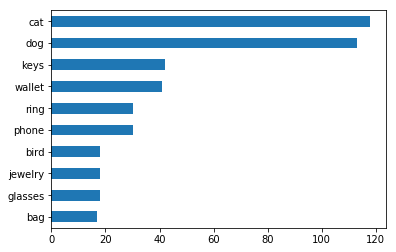

In [101]:
lost.Item.value_counts()[:10].sort_values().plot(kind = 'barh')

## Label the bar chart and make it easier to read by applying the FiveThirtyEight.Com style in Matplotlib

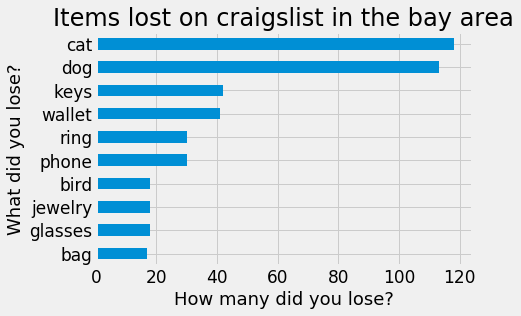

In [116]:
import matplotlib.style as style
style.use('fivethirtyeight')
lost_graph = lost.Item.value_counts()[:10].sort_values().plot(kind='barh',fontsize=17)
lost_graph.set_xlabel('How many did you lose?',fontsize=18)
lost_graph.set_ylabel('What did you lose?',fontsize=18)
lost_graph.set_title('Items lost on craigslist in the bay area',fontsize=24)
plt.show()

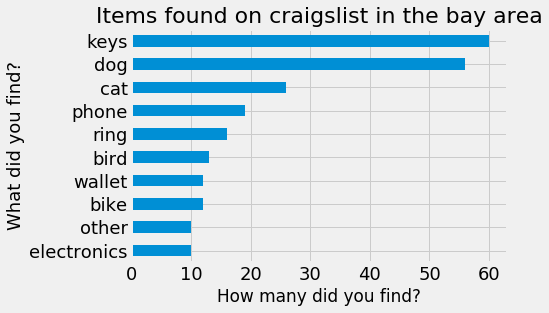

In [117]:
found_graph = found.Item.value_counts()[:10].sort_values().plot(kind='barh',fontsize=18)
found_graph.set_xlabel('How many did you find?',fontsize=17)
found_graph.set_ylabel('What did you find?',fontsize=18)
found_graph.set_title('Items found on craigslist in the bay area',fontsize=22)
plt.show()

## Create a graph comparing communities with the greatest number of items reported lost

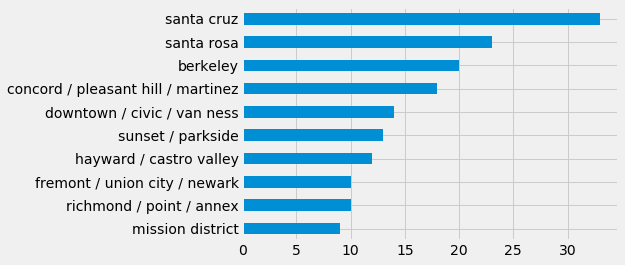

In [121]:
lost.Address.value_counts()[:10].sort_values().plot(kind = 'barh')

## Create Word Cloud visualization based on the frequency of words in the corpus

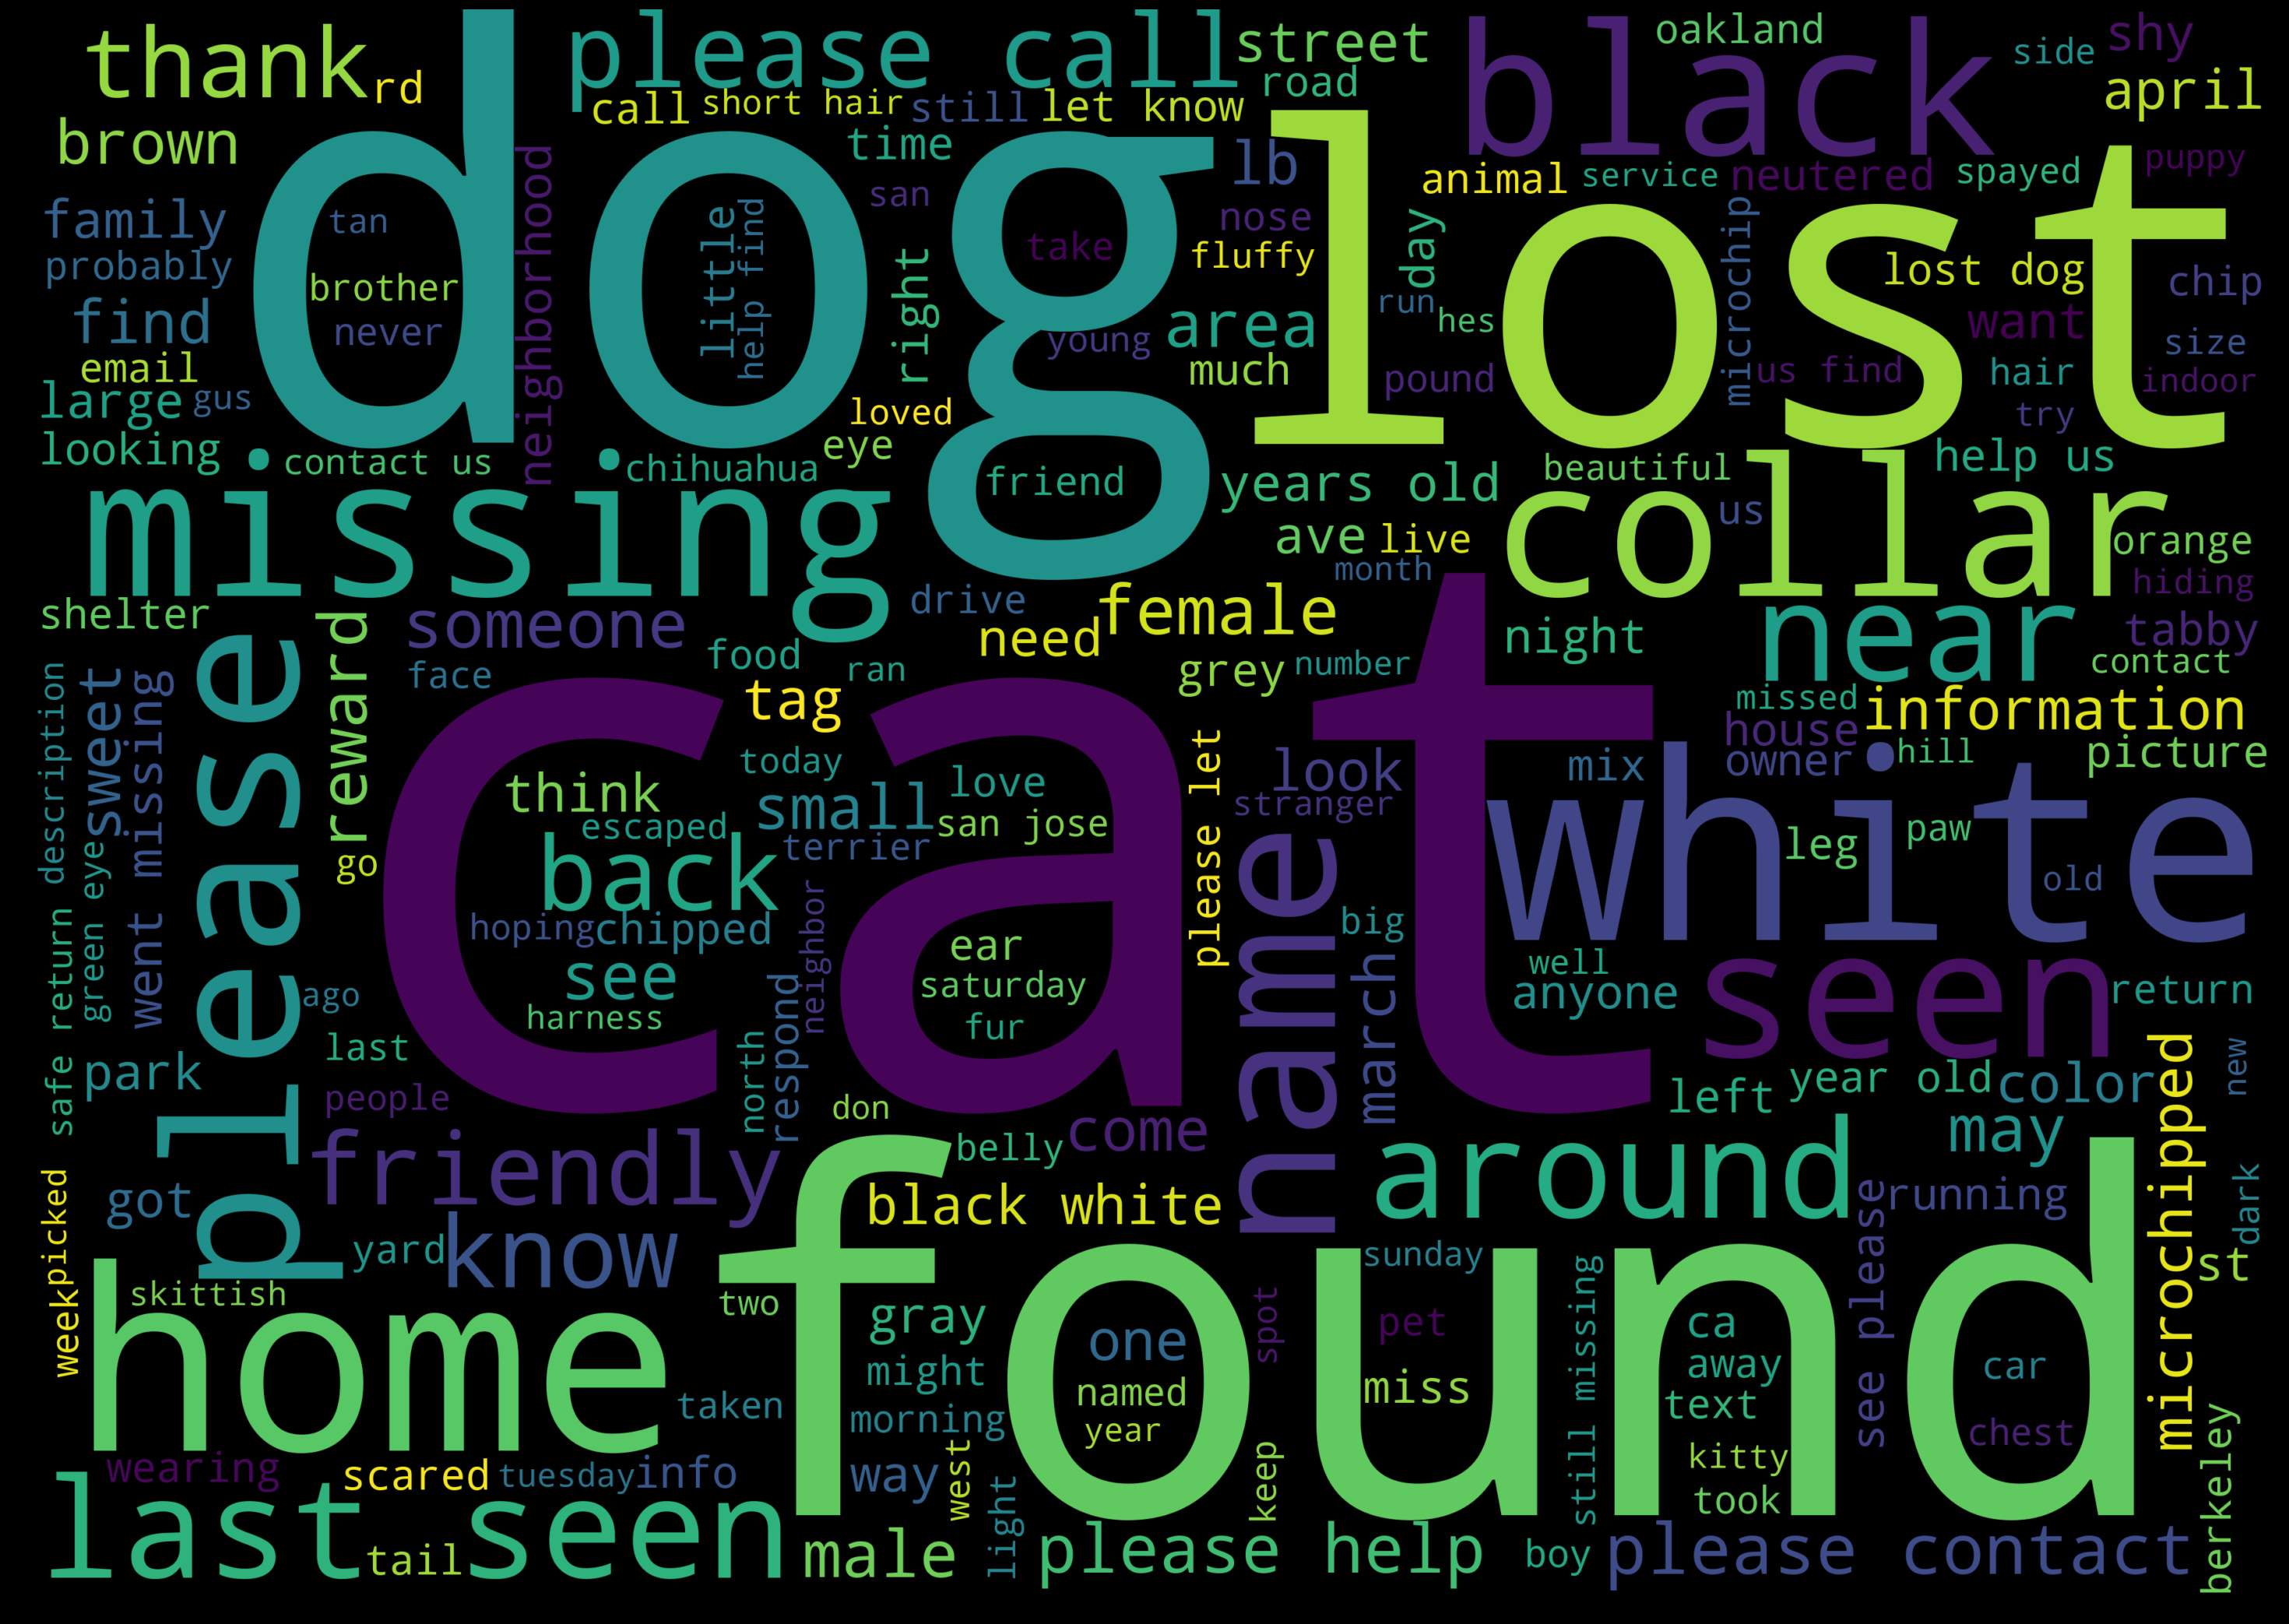

In [132]:
#wordcloud
from wordcloud import WordCloud, STOPWORDS
text = df.desc_nsw.values
wordcloud = WordCloud(
    width = 3500,
    height = 2500,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'black',
    edgecolor = 'blue')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
# Thanks to https://mikulskibartosz.name/word-cloud-from-a-pandas-dataframe-f3203cbf757

## Import packages for machine learning classification        

In [119]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter

from sklearn.feature_extraction.text import TfidfTransformer

## Multinomial Naive Bayes Classification Model to Predict Category Each Post Falls Into & Test Accuracy

In [135]:
counter = Counter(df['Item'].tolist())
top_10_items = {i[0]: idx for idx, i in enumerate(counter.most_common(10))}
df = df[df['Item'].map(lambda x: x in top_10_items)]

description_list = df['desc_nsw'].tolist()
item_list = [top_5_items[i] for i in df['Item'].tolist()]
item_list = np.array(item_list)

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(description_list)


tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

train_x, test_x, train_y, test_y = train_test_split(x_train_tfidf, item_list, test_size=0.3)

clf = MultinomialNB().fit(train_x, train_y)
y_score = clf.predict(test_x)

n_right = 0
for i in range(len(y_score)):
    if y_score[i] == test_y[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))

Accuracy: 82.98%
